In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")


print("Path to dataset files:", path)

Path to dataset files: C:\Users\sking\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
# Load MNIST
transform = transforms.ToTensor()
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [8]:
# Simple CNN
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10) 
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
# Train loop
model = DigitClassifier()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(1,31):
    model.train()
    for images, labels in train_loader:
        preds = model(images)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} done.")

NameError: name 'DigitClassifier' is not defined

In [10]:
#Save the model
torch.save(model.state_dict(), 'mnist_digit_classifier.pth')


NameError: name 'model' is not defined

In [5]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_digit(image_path, model):
    # Load the image
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  
        transforms.ToTensor(),       
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image).unsqueeze(0)  
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  
    
    return predicted.item() 



C:\Users\sking\AppData\Local\Temp\ipykernel_5240\1226766445.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_digit_classifier.pth"

The model predicts the digit is: 3


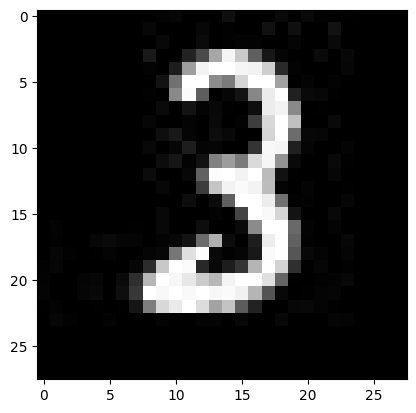

In [11]:

import matplotlib.pyplot as plt
# Example usage
# Load the saved model
model = DigitClassifier()
model.load_state_dict(torch.load("mnist_digit_classifier.pth"))
model.eval() 
image_path = "testSet/img_5.jpg"  # Replace with the path to your image
predicted_digit = predict_digit(image_path, model)
plt.imshow(Image.open(image_path).convert("L"), cmap='gray')
print(f"The model predicts the digit is: {predicted_digit}")

# Draw numbers to Test

Digit saved as drawn_digit.png
The model predicts the digit is: 0


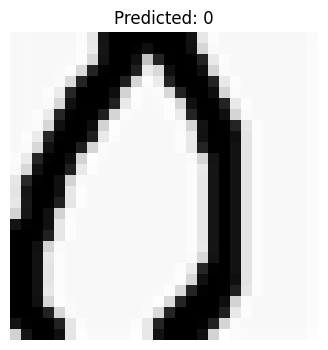

Canvas cleared
Digit saved as drawn_digit.png
The model predicts the digit is: 1


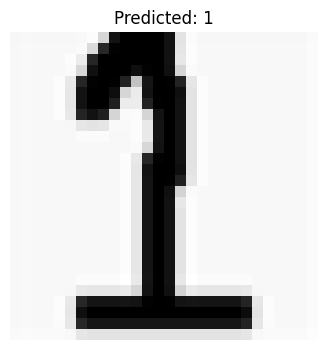

Canvas cleared
Digit saved as drawn_digit.png
The model predicts the digit is: 2


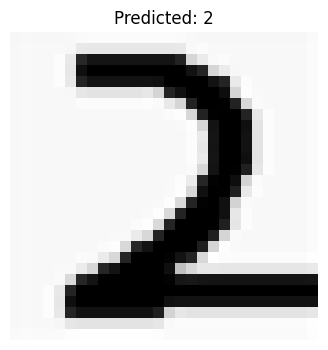

Drawing application closed
Press 'c' to clear, 'p' to predict, 'q' to quit


In [13]:
import pygame
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from io import BytesIO

# Initialize Pygame
pygame.init()

# Constants
WIDTH, HEIGHT = 280, 280
CELL_SIZE = 10
GRID_SIZE = WIDTH // CELL_SIZE
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (200, 200, 200)

# Create the display
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Draw a Digit")

# Initialize canvas as numpy array
canvas = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)

def draw_grid():
    screen.fill(WHITE)
    for x in range(0, WIDTH, CELL_SIZE):
        pygame.draw.line(screen, GRAY, (x, 0), (x, HEIGHT))
    for y in range(0, HEIGHT, CELL_SIZE):
        pygame.draw.line(screen, GRAY, (0, y), (WIDTH, y))

def draw_pixels():
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if canvas[i][j] > 0:
                pygame.draw.rect(screen, BLACK, (j*CELL_SIZE, i*CELL_SIZE, CELL_SIZE, CELL_SIZE))

def get_prediction():
    # Convert canvas to PIL Image
    surface_string = pygame.image.tostring(screen, 'RGB')
    img = Image.frombytes('RGB', (WIDTH, HEIGHT), surface_string).convert('L')
    img = img.resize((28, 28))
    
    # Save the drawn digit
    img.save("drawn_digit.png")
    print("Digit saved as drawn_digit.png")
    
    # Convert to tensor and predict
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    img_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    
    result = predicted.item()
    print(f"The model predicts the digit is: {result}")
    
    # Display the image with matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {result}")
    plt.axis('off')
    plt.show()
    
    return result

def run_drawing_app():
    global canvas
    
    running = True
    drawing = False
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            elif event.type == pygame.MOUSEBUTTONDOWN:
                drawing = True
                
            elif event.type == pygame.MOUSEBUTTONUP:
                drawing = False
                
            elif event.type == pygame.MOUSEMOTION and drawing:
                x, y = event.pos
                grid_x, grid_y = x // CELL_SIZE, y // CELL_SIZE
                
                # Make sure we're within bounds
                if 0 <= grid_x < GRID_SIZE and 0 <= grid_y < GRID_SIZE:
                    # Draw a thicker line for better visibility
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            nx, ny = grid_x + dx , grid_y +dy
                            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                                canvas[ny][nx] = 1
            
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_c:
                    # Clear canvas
                    canvas = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)
                    print("Canvas cleared")
                    
                elif event.key == pygame.K_p:
                    # Predict digit
                    get_prediction()
                    
                elif event.key == pygame.K_q:
                    # Quit
                    running = False
        
        draw_grid()
        draw_pixels()
        pygame.display.flip()
    
    pygame.quit()
    print("Drawing application closed")
    print("Press 'c' to clear, 'p' to predict, 'q' to quit")

# Run the application
run_drawing_app()